In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file, save_hdf5_file

import cooler

import sys
sys.path.insert(1, '/mnt/md0/jjusuf/absloopquant/AbsLoopQuant_analysis_code')
import looptools  # all the back end code is here

In [3]:
clr = cooler.Cooler('/mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data/contacts_3D_polysim_with_loopextr_with_EP_3kBT_all.cool')


In [4]:
files = list_URIs('/mnt/coldstorage/jjusuf/simabsloopquant_data/3D_polysim_data_final/3D_polysim_data_with_loopextr_with_EP_3kBT/')
print(f'+LE +EP: {len(files)} blocks')

+LE +EP: 1076000 blocks


In [5]:
files_no_EP = list_URIs('/mnt/coldstorage/jjusuf/simabsloopquant_data/3D_polysim_data_final/3D_polysim_data_with_loopextr_no_EP/')
print(f'+LE -EP: {len(files_no_EP)} blocks')

+LE -EP: 1082000 blocks


In [6]:
files_no_LE_no_EP = list_URIs('/mnt/coldstorage/jjusuf/simabsloopquant_data/3D_polysim_data_final/3D_polysim_data_no_loopextr_no_EP/')
print(f'-LE -EP: {len(files_no_LE_no_EP)} blocks')

-LE -EP: 1000000 blocks


# Get Micro-C scores

In [7]:
CTCF_loops_to_quantify_monomer_units = np.array([[200,574],
[330,574],
[200,694],
[300,694],
[200,866],
[330,866],
[724,866],
[724,1241],
[724,1390],
[724,1580],
[724,1752],
[1604,1752],
[1604,1800]])

EP_loops_to_quantify_monomer_units = np.array([[250,372],
[250,540],
[372,540],
[540,745],
[745,775],
[745,833],
[745,961],
[745,1202],
[775,833],
[775,961],
[833,961],
[833,1202],
[961,1202],
[961,1330],
[1202,1330],
[1640,1722]])

sim_loops_df = pd.DataFrame(np.concatenate((CTCF_loops_to_quantify_monomer_units, EP_loops_to_quantify_monomer_units)), columns=['left','right'])
sim_loops_df['left'] = 34000000 + sim_loops_df['left']*1000
sim_loops_df['right'] = 34000000 + sim_loops_df['right']*1000
sim_loops_df['type'] = None
sim_loops_df.loc[:len(CTCF_loops_to_quantify_monomer_units),'type'] = 'CTCF'
sim_loops_df.loc[len(CTCF_loops_to_quantify_monomer_units):,'type'] = 'EP'


In [8]:
sim_P_s_curve = np.loadtxt('/mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data/P_s_curve_data_3D_polysim_with_loopextr_with_EP_3kBT.txt')
lq = looptools.LoopQuantifier(clr, sim_P_s_curve);

for i in sim_loops_df.index:
    left, right, loop_type = sim_loops_df.loc[i][:3]
    size = right-left
    local_region_size = int(np.round(np.sqrt(size/1000/(32/25**2)))) * 1000  # in bp
    score = lq.quantify_loop('chrS', left, right, local_region_size=local_region_size, quant_region_size=10000)
    sim_loops_df.loc[i, 'Micro_C_score'] = score


# Get ground truth

In [9]:
region_size = 2000
num_chroms = 1
chrom_size = 70000
num_regions = chrom_size // region_size
region_starts = np.arange(num_regions) * region_size

def in_contact(pos1, pos2, SMC_pos):
    if pos1 in SMC_pos and pos2 in SMC_pos:
        pos1_ind = np.where(SMC_pos==pos1)[0][0]
        pos2_ind = np.where(SMC_pos==pos2)[0][0]
        SMC_pos_ext = np.concatenate((SMC_pos, SMC_pos+1, SMC_pos-1), axis=1)
        N = SMC_pos_ext.shape[0]
        common_matrix = np.zeros((N, N), dtype=bool)
        for i in range(N):
            for j in range(N):
                if np.any(np.isin(SMC_pos_ext[i,:],SMC_pos_ext[j,:])):
                    common_matrix[i, j] = True
        for k in range(N):
            for i in range(N):
                for j in range(N):
                    common_matrix[i, j] = common_matrix[i, j] or (common_matrix[i, k] and common_matrix[k, j])
        return common_matrix[pos1_ind, pos2_ind]
    else:
        return False

def calculate_GT_loop_prob_CTCF(files, pos1, pos2, block_start, block_end, block_step):
    #print(f'progress:\n[{" "*num_regions}]')
    #print('[', end='')
    mean_contacts = np.zeros(num_regions)
    for region_num in range(num_regions):
        region_start = region_starts[region_num]
        region_end = region_start + region_size
        blocks_to_sample = range(block_start, block_end, block_step)
        contact_arr = np.zeros(len(blocks_to_sample), dtype='int')
        for i, block_num in enumerate(blocks_to_sample):
            SMC_pos_all = load_URI(files[block_num])['SMCs']
            SMC_pos = SMC_pos_all[np.all((np.all(SMC_pos_all>=region_start, 1), np.all(SMC_pos_all<region_end, 1)), 0),:]  # filter for SMCs on chain
            SMC_pos = SMC_pos - region_start  # offset SMC positions to be in interval [0, mapN)
            if in_contact(pos1, pos2, SMC_pos):
                contact_arr[i] = 1
        mean_contacts[region_num] = np.mean(contact_arr)
        #print(f'=', end='')
    #print(']')
    return np.mean(mean_contacts)

def calculate_contact_freq(files, pos1, pos2, block_start, block_end, block_step, cutoff):
    blocks_to_sample = np.arange(block_start, block_end, block_step)
    mean_contacts = np.zeros(len(blocks_to_sample))
    for i, block_num in enumerate(blocks_to_sample):
        monomer_positions = load_URI(files[block_num])['pos']
        displacement_vectors = monomer_positions[region_starts+pos1]-monomer_positions[region_starts+pos2]
        distances = np.linalg.norm(displacement_vectors, axis=1)
        mean_contacts[i] = np.mean(distances < cutoff)
    return np.mean(mean_contacts)


In [10]:
block_start = 500000
block_end = 1000000
block_step = 1000

In [21]:
for i in np.where(sim_loops_df['type']=='CTCF')[0]:
    pos1 = (sim_loops_df.loc[i, 'left']-34000000)//1000  # convert back to monomer units
    pos2 = (sim_loops_df.loc[i, 'right']-34000000)//1000
    abs_loop_prob = calculate_GT_loop_prob_CTCF(files, pos1, pos2, block_start, block_end, block_step)
    sim_loops_df.loc[i,'abs_loop_prob'] = abs_loop_prob
    print(f'{pos1}-{pos2}: {abs_loop_prob}')

200-574: 0.06331428571428573
330-574: 0.04022857142857143
200-694: 0.045942857142857146
300-694: 0.0007428571428571429
200-866: 0.011542857142857143
330-866: 0.007257142857142857
724-866: 0.1849142857142857
724-1241: 0.010571428571428572
724-1390: 0.04125714285714285
724-1580: 0.012057142857142858
724-1752: 0.005942857142857143
1604-1752: 0.07359999999999998
1604-1800: 0.0036


In [16]:
cutoff = 3
for i in np.where(sim_loops_df['type']=='EP')[0]:
    pos1 = (sim_loops_df.loc[i, 'left']-34000000)//1000  # convert back to monomer units
    pos2 = (sim_loops_df.loc[i, 'right']-34000000)//1000
    contact_freq = calculate_contact_freq(files, pos1, pos2, block_start, block_end, block_step, cutoff)
    contact_freq_no_EP = calculate_contact_freq(files_no_EP, pos1, pos2, block_start, block_end, block_step, cutoff)
    abs_loop_prob = contact_freq-contact_freq_no_EP
    sim_loops_df.loc[i,'abs_loop_prob'] = abs_loop_prob
    print(f'{pos1}-{pos2}: {abs_loop_prob:.5f}')

250-372: 0.02440
250-540: 0.01320
372-540: 0.02034
540-745: 0.01411
745-775: 0.11623
745-833: 0.05274
745-961: 0.01943
745-1202: 0.01337
775-833: 0.05903
775-961: 0.02006
833-961: 0.02269
833-1202: 0.01520
961-1202: 0.01686
961-1330: 0.01206
1202-1330: 0.02194
1640-1722: 0.03543


# Save data

In [44]:
sim_loops_df.to_csv('/mnt/md0/jjusuf/absloopquant/AbsLoopQuant_data/simulation_calibration_curve.csv')

# Make plot

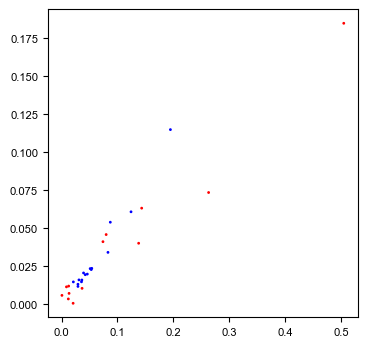

In [45]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(sim_loops_df['Micro_C_score'],sim_loops_df['abs_loop_prob'], 1, c=1*(sim_loops_df['type']=='CTCF'), cmap='bwr')